In [1]:
import seaborn as sns
sns.set_theme()

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

class Frog:
    def __init__(self, 
                 n=10, 
                 gamma=0.99, 
                 initial_alpha=0.1, 
                 initial_eps=0.9, 
                 num_simulations = 50,
                 hyperparameter_scheme=2, 
                 rewards_choice=2):
        
        self.n = n
        self.gamma = gamma
        self.initial_alpha = initial_alpha
        self.initial_eps = initial_eps
        self.state_space = list(range(n+1))
        self.terminal_space = [0, n]
        self.action_space = ['A', 'B']
        
        self.hyperparameter_scheme = hyperparameter_scheme
        self.rewards_choice = rewards_choice
        
        #initialization - might impact the speed of training (especially in early stages), but should not impact the outcome
        #self.Q = np.zeros([len(self.state_space), len(self.action_space)])
        self.Q = np.random.rand(len(self.state_space), len(self.action_space))
        
        self.num_simulations = num_simulations
        self.simulated_rewards = []
    
    
    def eps_greedy_action(self, eps):
        rv = np.random.uniform(0,1)
        if rv < eps:
            #random action
            return np.random.choice(self.action_space)
        else:
            #follow the best action
            return self.action_space[np.argmax(self.Q[self.state, :])]

    
    def action_A(self, state):
        rv = np.random.uniform(0,1)
        if rv < float(state)/self.n:
            return state - 1
        else:
            return state + 1
        
    def action_B(self, state):
        state_space = list(self.state_space)
        state_space.pop(state)
        return np.random.choice(state_space)
    
    def choose_reward_function(self, state):
        if self.rewards_choice == 1:
            return self.get_reward(state)
        elif self.rewards_choice == 2:
            return self.get_reward2(state)
        else:
            print("ERROR! Unknown reward function")
    
    def get_reward(self, state):
        #reward assignment - you can experiment with different rewards
        return float(state)/self.n
        
    def get_reward2(self, state):
        #reward assignment - you can experiment with different rewards
        if state == 0:
            return 0
        elif state == self.n:
            return 1
        else:
            return 0
        
    def simulate(self, num_simulation):
        simulated_rewards = []
        number_of_games_won = 0
        
        for i in range(num_simulation):
            state = np.random.randint(1, self.n - 1)
            reward = 0
            while state not in self.terminal_space:
                #follow the best policy
                action = self.action_space[np.argmax(self.Q[state, :])]            
                if action == 'A':
                    state_new = self.action_A(state)
                else:
                    state_new = self.action_B(state)
                reward += self.choose_reward_function(state_new)
                state = state_new  
                
                if state == self.n:
                    number_of_games_won += 1 
                    
            simulated_rewards.append(reward)
        #return cumlated rewards over num_episode simulations for a given policy
        proportion_of_games_won = number_of_games_won/num_simulation
        
        return np.mean(simulated_rewards), proportion_of_games_won
    
    def simulate_for_large_n(self, num_simulation):
        #this function might be useful for testing/debugging your code for large n
        simulated_rewards = []
        for i in range(num_simulation):
            state = np.random.randint(1, self.n - 1)
            reward = 0
            num_iter = 0
            while state not in self.terminal_space and (num_iter<0.5e7):
                #with a small probability pick action B not to be stuck in the infinite loop traversing the lilypads,
                #otherwise follow the best policy
                rv = np.random.uniform(0,1)
                if rv < 1e-2:
                    action = 'B'
                else:
                    action = self.action_space[np.argmax(self.Q[state, :])]              
                if action == 'A':
                    state_new = self.action_A(state)
                else:
                    state_new = self.action_B(state)
                reward += self.choose_reward_function(state_new)
                
                print("reward = ", reward)
                state = state_new
                print("state =", state_new)
                num_iter +=1
            if (num_iter<0.5e7):
                simulated_rewards.append(reward)
            else: 
                print("Dropped rewards due to large time needed to simulate")
        #return cumlated rewards over num_episode simulations for a given policy (this value is calibrated to n=25)
        return np.mean(simulated_rewards)
    
    def choose_hyperparameter_scheme(self, i, num_episode):
        if self.hyperparameter_scheme == 1:
            return self.my_hyperparameter_scheme_1(i, num_episode)
        elif self.hyperparameter_scheme == 2:
            return self.my_hyperparameter_scheme_2(i, num_episode)
        elif self.hyperparameter_scheme == 3:
            return self.my_hyperparameter_scheme_3(i, num_episode)
        else:
            print("ERROR! Unknown hyperparameter scheme")
    
    def my_hyperparameter_scheme_1(self, i, num_episode):
        if i<500:
            eps =  self.initial_eps
            alpha = float(self.initial_alpha*(num_episode - i))/num_episode
        else:
            eps = 0
            alpha = float(self.initial_alpha*(num_episode - i))/num_episode/10
        return [eps, alpha]
    
    def my_hyperparameter_scheme_2(self, i, num_episode):
        eps =  self.initial_eps
        alpha = float(self.initial_alpha*(num_episode - i))/num_episode
        return [eps, alpha]
    
    
    def my_hyperparameter_scheme_3(self, i, num_episode):
        eps =  float(self.initial_eps*(num_episode - i))/num_episode
        alpha = float(self.initial_alpha*(num_episode - i))/num_episode
        return [eps, alpha]

    def q_learning(self, num_episode):
        self.list_norm_differences = []
        self.list_proportion_of_games_won = []
        
        for i in range(num_episode):
            old_Q = self.Q.copy()
            if i%50 == 0:
                print("Episode: ", i)
            self.state = np.random.randint(1, self.n - 1)
            
            #my hyperparameter scheme - feel free to implement your own
            [eps, alpha] = self.choose_hyperparameter_scheme(i, num_episode)

            while self.state not in self.terminal_space:
                #epsilon-greedy action selection
                action = self.eps_greedy_action(eps)
                #follow action to a new state
                if action == 'A':
                    state_new = self.action_A(self.state)
                else:
                    state_new = self.action_B(self.state)
                #get reward at a new state
                reward = self.choose_reward_function(state_new)
                #Q-update
                self.Q[self.state, self.action_space.index(action)] += alpha * (reward + self.gamma * np.max(self.Q[state_new, :]) - self.Q[self.state, self.action_space.index(action)])
                self.state = state_new
                
            #now simulated rewards for the fixed Q table
            reward_obtained_during_simulation, proportion_of_games_won = self.simulate(self.num_simulations)
            self.simulated_rewards.append(reward_obtained_during_simulation) 
            self.list_proportion_of_games_won.append(proportion_of_games_won)
            
            
        
            norm_difference = np.linalg.norm(self.Q - old_Q)
            self.list_norm_differences.append(norm_difference)
            

    def all_plots(self):
        plt.figure(figsize=(15, 4))
        plt.subplot(121)
        plt.title("Q*-values")
        plt.plot(self.Q[:,0], label='A')
        plt.plot(self.Q[:,1], label='B')
        plt.xlabel('State')
        plt.xlim((1, self.n-1))
        plt.xticks(range(1, self.n))
        plt.legend()
        plt.subplot(122)
        plt.title("Average Cumulative Rewards Over {} Simulations".format(self.num_simulations))
        plt.plot(pd.Series(self.simulated_rewards))
        plt.plot(pd.Series(self.simulated_rewards).rolling(10).mean())
        plt.xlabel('Training Episode')
        plt.show()

# n = 3

Episode:  0
Episode:  50
Episode:  100
Episode:  150
Episode:  200
Episode:  250
Episode:  300
Episode:  350
Episode:  400
Episode:  450
Episode:  500
Episode:  550
Episode:  600
Episode:  650
Episode:  700
Episode:  750
Episode:  800
Episode:  850
Episode:  900
Episode:  950


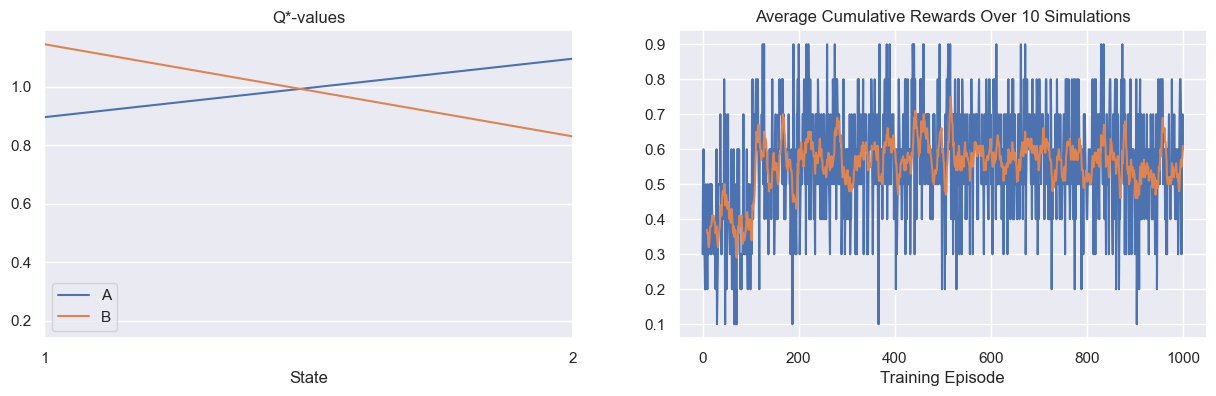

In [7]:
myFrog_3 = Frog(n=3, gamma = 0.999, initial_alpha = 0.01, initial_eps = 0.999, num_simulations = 10, hyperparameter_scheme = 3, rewards_choice = 2)
myFrog_3.q_learning(1000)
myFrog_3.all_plots()

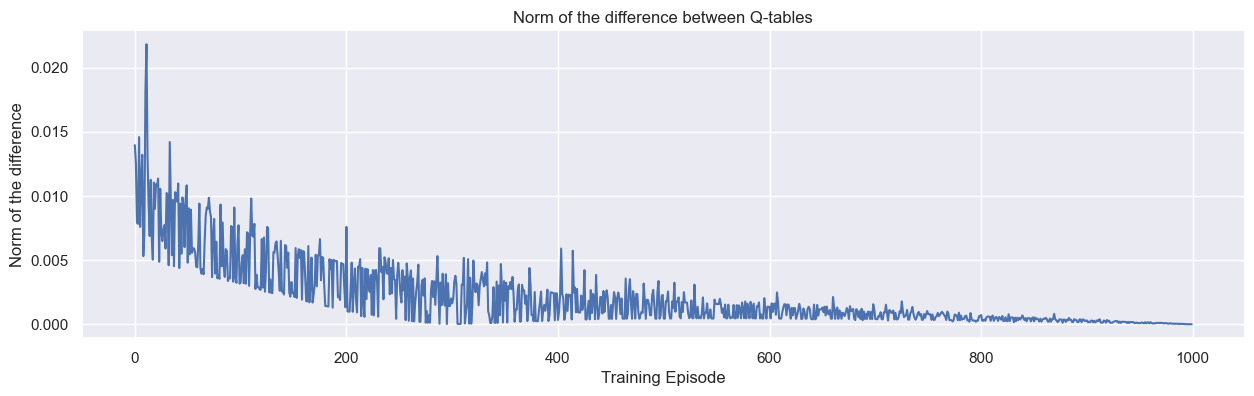

In [8]:
fig = plt.figure(figsize=(15, 4))
plt.plot(myFrog_3.list_norm_differences)
plt.title("Norm of the difference between Q-tables")
plt.xlabel('Training Episode')
plt.ylabel('Norm of the difference')
plt.show()
fig.savefig('norm_of_difference_3.png')

# n = 10

Episode:  0
Episode:  50
Episode:  100
Episode:  150
Episode:  200
Episode:  250
Episode:  300
Episode:  350
Episode:  400
Episode:  450
Episode:  500
Episode:  550
Episode:  600
Episode:  650
Episode:  700
Episode:  750
Episode:  800
Episode:  850
Episode:  900
Episode:  950


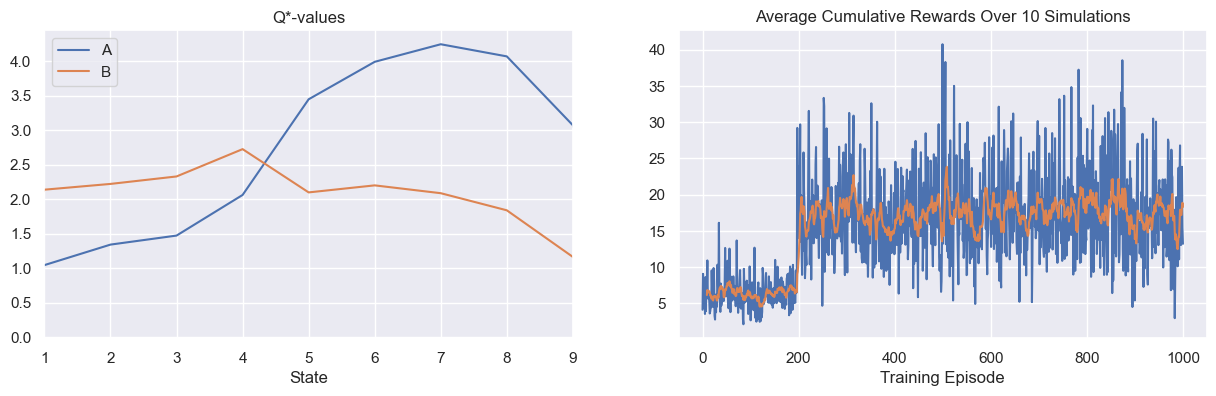

In [33]:
myFrog_10 = Frog(n=10, gamma = 0.999, initial_alpha = 0.01, initial_eps = 0.999, num_simulations = 10, hyperparameter_scheme = 3, rewards_choice = 1)
myFrog_10.q_learning(1000)
myFrog_10.all_plots()

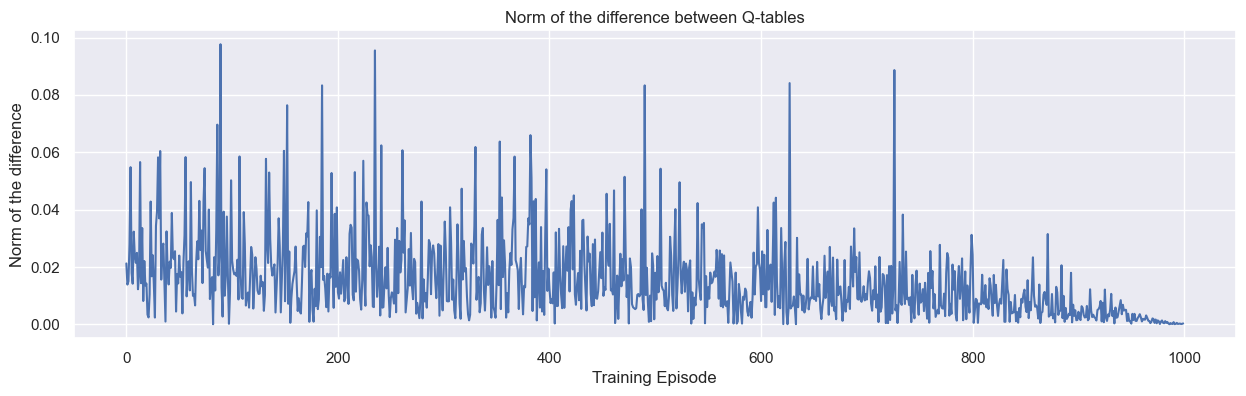

In [34]:
fig = plt.figure(figsize=(15, 4))
plt.plot(myFrog_10.list_norm_differences)
plt.title("Norm of the difference between Q-tables")
plt.xlabel('Training Episode')
plt.ylabel('Norm of the difference')
plt.show()
fig.savefig('norm_of_difference_10.png')

# n = 25

Episode:  0
Episode:  50
Episode:  100
Episode:  150
Episode:  200
Episode:  250
Episode:  300
Episode:  350
Episode:  400
Episode:  450
Episode:  500
Episode:  550
Episode:  600
Episode:  650
Episode:  700
Episode:  750
Episode:  800
Episode:  850
Episode:  900
Episode:  950


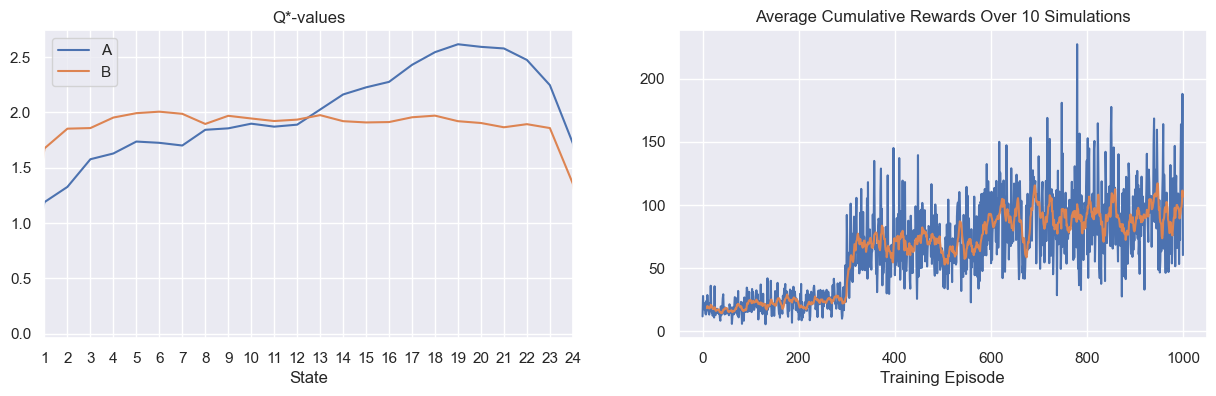

In [35]:
myFrog_25 = Frog(n=25, gamma = 0.999, initial_alpha = 0.01, initial_eps = 0.999, num_simulations = 10, hyperparameter_scheme = 2, rewards_choice = 1)
myFrog_25.q_learning(1000)
myFrog_25.all_plots()

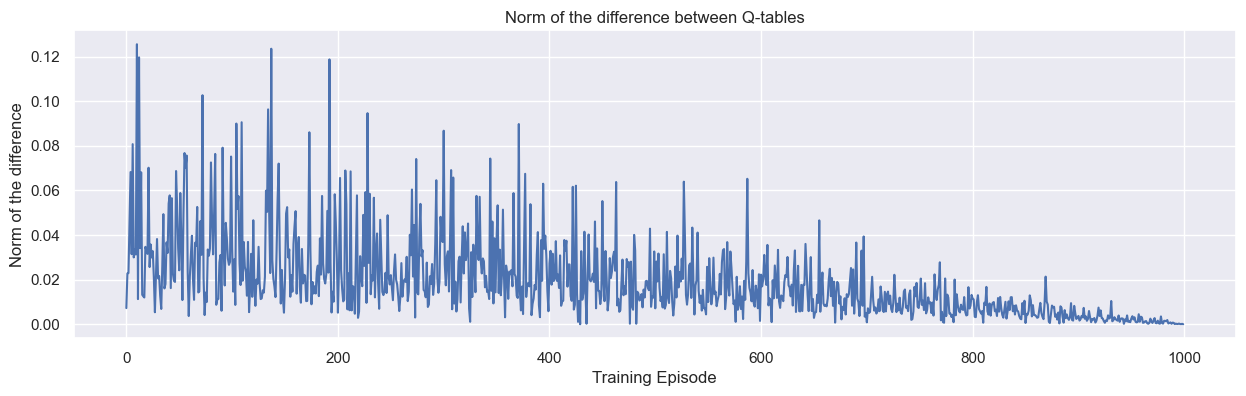

In [36]:
fig = plt.figure(figsize=(15, 4))
plt.plot(myFrog_25.list_norm_differences)
plt.title("Norm of the difference between Q-tables")
plt.xlabel('Training Episode')
plt.ylabel('Norm of the difference')
plt.show()
fig.savefig('norm_of_difference_25.png')